### prognostic drifts

Figures showing drifts in variables over 40-day prognostic runs with various configurations (RF, NN, baseline)

In [1]:
import fsspec
import xarray as xr
import intake
from matplotlib import pyplot as plt, ticker, dates as mdates
import matplotlib
matplotlib.rcParams.update({'font.size': 10})
from dask.diagnostics import ProgressBar
import os
from vcm.catalog import catalog as CATALOG
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm.convenience import cast_to_datetime, convert_timestamps
from vcm import interpolate_to_pressure_levels
from vcm.select import zonal_average_approximate
from typing import Mapping, Sequence
import numpy as np
import string

In [2]:
grid = CATALOG['grid/c48'].to_dask()
AREA = grid['area'].load()
LAT = grid['lat'].load()

DRIFT_TS_VARS = {
    '200hPa temperature': {'tmp200_spatial_mean_dycore_global': 'TMP200'},
    '850hPa temperature': {'tmp850_spatial_mean_dycore_global': 'TMP850'},
    'precipitable water': {'pwat_spatial_mean_dycore_global': 'PWAT'},
}

RUN_KWARGS = [
    {
        'name': 'random forests',
        'url': {'state': ['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000']},
        'drift_vars': DRIFT_TS_VARS
    },
    {
        'name': 'neural networks',
        'url': {'state': ["gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/20160805.000000"]},
        'drift_vars': DRIFT_TS_VARS
    },
    {
        'name': 'baseline physics',
        'url': {'state': ['gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805-start-rad-step-1800s']},
        'drift_vars': DRIFT_TS_VARS
    },
    {
        'name': 'coarsened fine-res',
        'url': {
            'state': ['40day_c48_restarts_as_zarr_may2020'],
            'diags': ['40day_c48_atmos_8xdaily_additional_vars_may2020', '40day_c48_atmos_8xdaily_may2020']
        },
        'drift_vars': DRIFT_TS_VARS,
        'verif': True
    },
    {
        'name': 'NN-seed-0',
        'url': {'state': ['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-0/prognostic_run_sfc_rad_rectified']},
        'drift_vars': DRIFT_TS_VARS
    },
    {
        'name': 'NN-seed-1',
        'url': {'state': ['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-1/prognostic_run_sfc_rad_rectified']},
        'drift_vars': DRIFT_TS_VARS
    },
    {
        'name': 'NN-seed-2',
        'url': {'state': ['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-2/prognostic_run_sfc_rad_rectified']},
        'drift_vars': DRIFT_TS_VARS
    },
    {
        'name': 'NN-seed-3',
        'url': {'state': ['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-3/prognostic_run_sfc_rad_rectified']},
        'drift_vars': DRIFT_TS_VARS
    }
]

DELP = 'pressure_thickness_of_atmospheric_layer'
DELZ = 'vertical_thickness_of_atmospheric_layer'
PHIS = 'surface_geopotential'
T = 'air_temperature'
q = 'specific_humidity'
GRAVITY = 9.81
LV = 2.5e6  # J/kg
CP =  1004.  # J/kg/K

VERIF_STATE_RENAME = {
    'pfull': 'z',
    'DZ': DELZ,
    'delp': DELP,
    'T': T,
    'sphum': q,
    'phis': PHIS
}

OUTDIR = 'figures'

In [3]:
def global_mean(da, area, dims = ['x', 'y', 'tile']):
    area = area.where(~np.isnan(da))
    return ((da*area).sum(dim=dims))/(area.sum(dim=dims))

In [4]:
class Fv3gfsRun:
    
    def __init__(self, name, url, drift_vars, verif=False):
        self.name: str = name
        self.url: Mapping[str, Sequence[str]] = url
        self.drift_vars: Mapping[str, Mapping[str, str]] = drift_vars
        self.verif: bool = verif
        self._diags: xr.Dataset = self._get_diags()
        self._state: xr.Dataset = self._get_state()
        with ProgressBar():
            self.global_mean_ts: xr.Dataset = self._global_mean_ts().load()
            mean_temp_lat_pressure, mean_temp_lat = self._mean_temp_lat_pressure()
            self.mean_temp_lat_pressure: xr.DataArray = mean_temp_lat_pressure.load()
            self.mean_temp_lat: xr.DataArray = mean_temp_lat.load()
        
    def _global_mean_ts(self):
        global_mean_ts = {}
        for plot_name, var_names in self.drift_vars.items():
            diags_name = list(var_names.keys())[0]
            verif_name = list(var_names.values())[0]
            if diags_name in self._diags:
                global_mean_ts[plot_name] = self._diags[diags_name]
            else:
                global_mean_ts[plot_name] = global_mean(self._diags[verif_name], AREA)
        return xr.Dataset(global_mean_ts)
    
    def _mean_temp_lat(self):
        T_pressure = interpolate_to_pressure_levels(self._state[T], self._state[DELP], dim='z')
        T200_lat = zonal_average_approximate(LAT, T_pressure.sel({'pressure': 20000}))
        T200_lat = T200_lat.sel({'time': T200_lat.time.loc[T200_lat.time >= np.datetime64('2016-08-21')]})
        return T200_lat.mean('time').assign_attrs(self._state[T].attrs)
    
    def _mean_temp_lat_pressure(self):
        T_pressure = interpolate_to_pressure_levels(self._state[T], self._state[DELP], dim='z')
        T_pressure_lat = (
            zonal_average_approximate(LAT, T_pressure)
            .sel({'time': T_pressure.time.loc[T_pressure.time >= np.datetime64('2016-08-21')]})
        )
        T200_lat = T_pressure_lat.sel({'pressure': 20000})
        T200_lat = T200_lat.mean('time').assign_attrs(self._state[T].attrs)
        T_pressure_lat = T_pressure_lat.mean('time').assign_attrs(self._state[T].attrs)
        return T_pressure_lat, T200_lat
    
    @staticmethod
    def _subset_time(ds, hour, minute):
        return ds.sel(time=ds.time.loc[
            (ds.time.dt.hour == hour) & (ds.time.dt.minute == minute) 
            & (ds.time >= np.datetime64('2016-08-05')) 
            & (ds.time <= np.datetime64('2016-09-10')) 
        ])
    
    @staticmethod
    def _cast_to_datetime(ds):
        cast = np.vectorize(cast_to_datetime)
        return ds.assign_coords({'time': cast(ds.time)})
    
    @staticmethod
    def _convert_timestamps(ds):
        return ds.assign_coords({'time': convert_timestamps(ds.time)})
    
    def _get_state(self):
        if self.verif:
            ds = self._get_verif_state()
        else:
            ds = self._get_prog_state()
        return (
            ds.pipe(self._cast_to_datetime)
            .pipe(self._subset_time, hour=0, minute=0)
        )      
    
    def _get_diags(self):
        if self.verif:
            ds = self._get_verif_diags()
        else:
            ds = self._get_prog_diags()
        return (
            ds.pipe(self._cast_to_datetime)
            .pipe(self._subset_time, hour=0, minute=0)
        ) 
    
    def _get_verif_diags(self):
        diags = []
        for diags_path in self.url['diags']:
            print(f"Loading {self.name} diags at {diags_path}.")
            diags.append(standardize_fv3_diagnostics(CATALOG[diags_path].to_dask()))
        return xr.merge(diags)
    
    def _get_verif_state(self):
        assert len(self.url['state']) == 1
        print(f"Loading {self.name} state at {self.url['state'][0]}.")
        ds = CATALOG[self.url['state'][0]].to_dask()
        return (
            ds.pipe(self._convert_timestamps)
            .pipe(standardize_fv3_diagnostics)
            .rename(VERIF_STATE_RENAME)
        )
    
    def _get_prog_diags(self):
        assert len(self.url['state']) == 1
        diags_path = self._get_diags_path(self.url['state'][0])
        print(f"Loading {self.name} diags at {diags_path}.")
        with fsspec.open(diags_path, 'rb') as f:
            ds = xr.open_dataset(f).load()
        return standardize_fv3_diagnostics(ds)
            
    def _get_prog_state(self):
        state_path = os.path.join(self.url['state'][0], 'state_after_timestep.zarr')
        print(f"Loading {self.name} state at {state_path}.")
        return standardize_fv3_diagnostics(intake.open_zarr(state_path, consolidated=True).to_dask())
    
    @staticmethod
    def _get_diags_path(run_url):
        prefix = 'gs://vcm-ml-archive/prognostic_run_diags'
        path_suffix = run_url.split('gs://')[1].replace("/", "-")
        return os.path.join(prefix, path_suffix, 'diags.nc')

In [5]:
run_list = [Fv3gfsRun(**kwargs) for kwargs in RUN_KWARGS]

Loading random forests diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-rf-initial_conditions_runs-20160805.000000/diags.nc.
Loading random forests state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  2.6s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 48.5s
[#                                       ] | 4% Completed |  3.1s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 42.8s
Loading neural networks diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-nn-ensemble-model-initial_conditions_runs_rectified_nn_rad-20160805.000000/diags.nc.
Loading neural networks state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/20160805.000000/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  4.2s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 56.1s
[#                                       ] | 4% Completed |  3.8s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 44.6s
Loading baseline physics diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-04-13-baseline-physics-run-20160805-start-rad-step-1800s/diags.nc.
Loading baseline physics state at gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805-start-rad-step-1800s/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  4.0s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.5s
[#                                       ] | 4% Completed |  2.6s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 39.6s
Loading coarsened fine-res diags at 40day_c48_atmos_8xdaily_additional_vars_may2020.
Loading coarsened fine-res diags at 40day_c48_atmos_8xdaily_may2020.
Loading coarsened fine-res state at 40day_c48_restarts_as_zarr_may2020.
[########################################] | 100% Completed |  1.7s


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[                                        ] | 0% Completed |  1.0s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 38.8s
[                                        ] | 0% Completed |  0.7s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 23.6s
Loading NN-seed-0 diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-nn-seed-0-prognostic_run_sfc_rad_rectified/diags.nc.
Loading NN-seed-0 state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-0/prognostic_run_sfc_rad_rectified/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  4.2s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  5.2s
[#                                       ] | 4% Completed |  3.0s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 40.9s
Loading NN-seed-1 diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-nn-seed-1-prognostic_run_sfc_rad_rectified/diags.nc.
Loading NN-seed-1 state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-1/prognostic_run_sfc_rad_rectified/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  3.5s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.4s
[#                                       ] | 4% Completed |  2.6s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 45.9s
Loading NN-seed-2 diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-nn-seed-2-prognostic_run_sfc_rad_rectified/diags.nc.
Loading NN-seed-2 state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-2/prognostic_run_sfc_rad_rectified/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  3.9s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 59.1s
[#                                       ] | 4% Completed |  2.2s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 45.1s
Loading NN-seed-3 diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-nn-seed-3-prognostic_run_sfc_rad_rectified/diags.nc.
Loading NN-seed-3 state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn/seed-3/prognostic_run_sfc_rad_rectified/state_after_timestep.zarr.


/home/brianh/dev/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],


[#                                       ] | 4% Completed |  3.5s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.4s
[#                                       ] | 4% Completed |  2.1s

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 40.8s


In [6]:
def _plot_global_ts(ax, runlist, var):
    for run in [run for run in runlist if "NN-seed" not in run.name]:
        ax.plot(run.global_mean_ts.time, run.global_mean_ts[var], label=run.name)
    nn_seed_ds = xr.concat([run.global_mean_ts for run in runlist if "NN-seed" in run.name], dim='seed', join='inner')
    ax.fill_between(
        nn_seed_ds.time.values,
        nn_seed_ds[var].min(dim='seed'),
        nn_seed_ds[var].max(dim='seed'),
        color=[h.get_color() for h in ax.get_lines() if h.get_label() == 'neural networks'][0],
        alpha=0.2
    )
    ax.set_xlim([np.datetime64('2016-08-06'), np.datetime64('2016-09-10')])
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SA))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_ylabel(runlist[0].global_mean_ts[var].attrs.get('units'))
        
def _plot_temp200_bias_lat(ax, runlist):
    run_names = [run.name for run in runlist if 'NN-seed' not in run.name]
    t200 = (
        xr.concat(
            [run.mean_temp_lat for run in runlist if 'NN-seed' not in run.name],
            dim=xr.DataArray(run_names, dims='runs', coords={'runs': run_names})
        )
    ).assign_attrs({'units': 'K'})
    h = t200.plot(ax=ax, hue='runs', add_legend=False)
    nn_seed_ds = xr.concat([run.mean_temp_lat for run in runlist if "NN-seed" in run.name], dim='seed', join='inner')
    ax.fill_between(
        nn_seed_ds.lat.values,
        nn_seed_ds.min(dim='seed'),
        nn_seed_ds.max(dim='seed'),
        color=[ax.get_color() for ax in ax.get_lines()][run_names.index('neural networks')],
        alpha=0.2
    )
    ax.set_xlabel('latitude [deg]')
    ax.set_xlim([-90, 90])
    ax.set_ylabel('K')

def plot_global_drifts(runlist, varnames):
    fig, axes = plt.subplots(2, 2)
    for i, (ax, var) in enumerate(zip(axes.flatten(), varnames)):
        if var != '200hPa time- and zonal-mean temperature':
            _plot_global_ts(ax, runlist, var)
        else:
            _plot_temp200_bias_lat(ax, runlist)
        ax.grid(axis='y')
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        if i == 0:
            h, l = ax.get_legend_handles_labels()
            ax.legend(h, l)
        ax.set_title(f"{string.ascii_lowercase[i]}) {var}")
    fig.set_size_inches([10, 8])
    fig.set_dpi(150)
    fig.tight_layout()
    fig.savefig(f"{OUTDIR}/prognostic-drifts.png", bbox_inches='tight', facecolor='white')

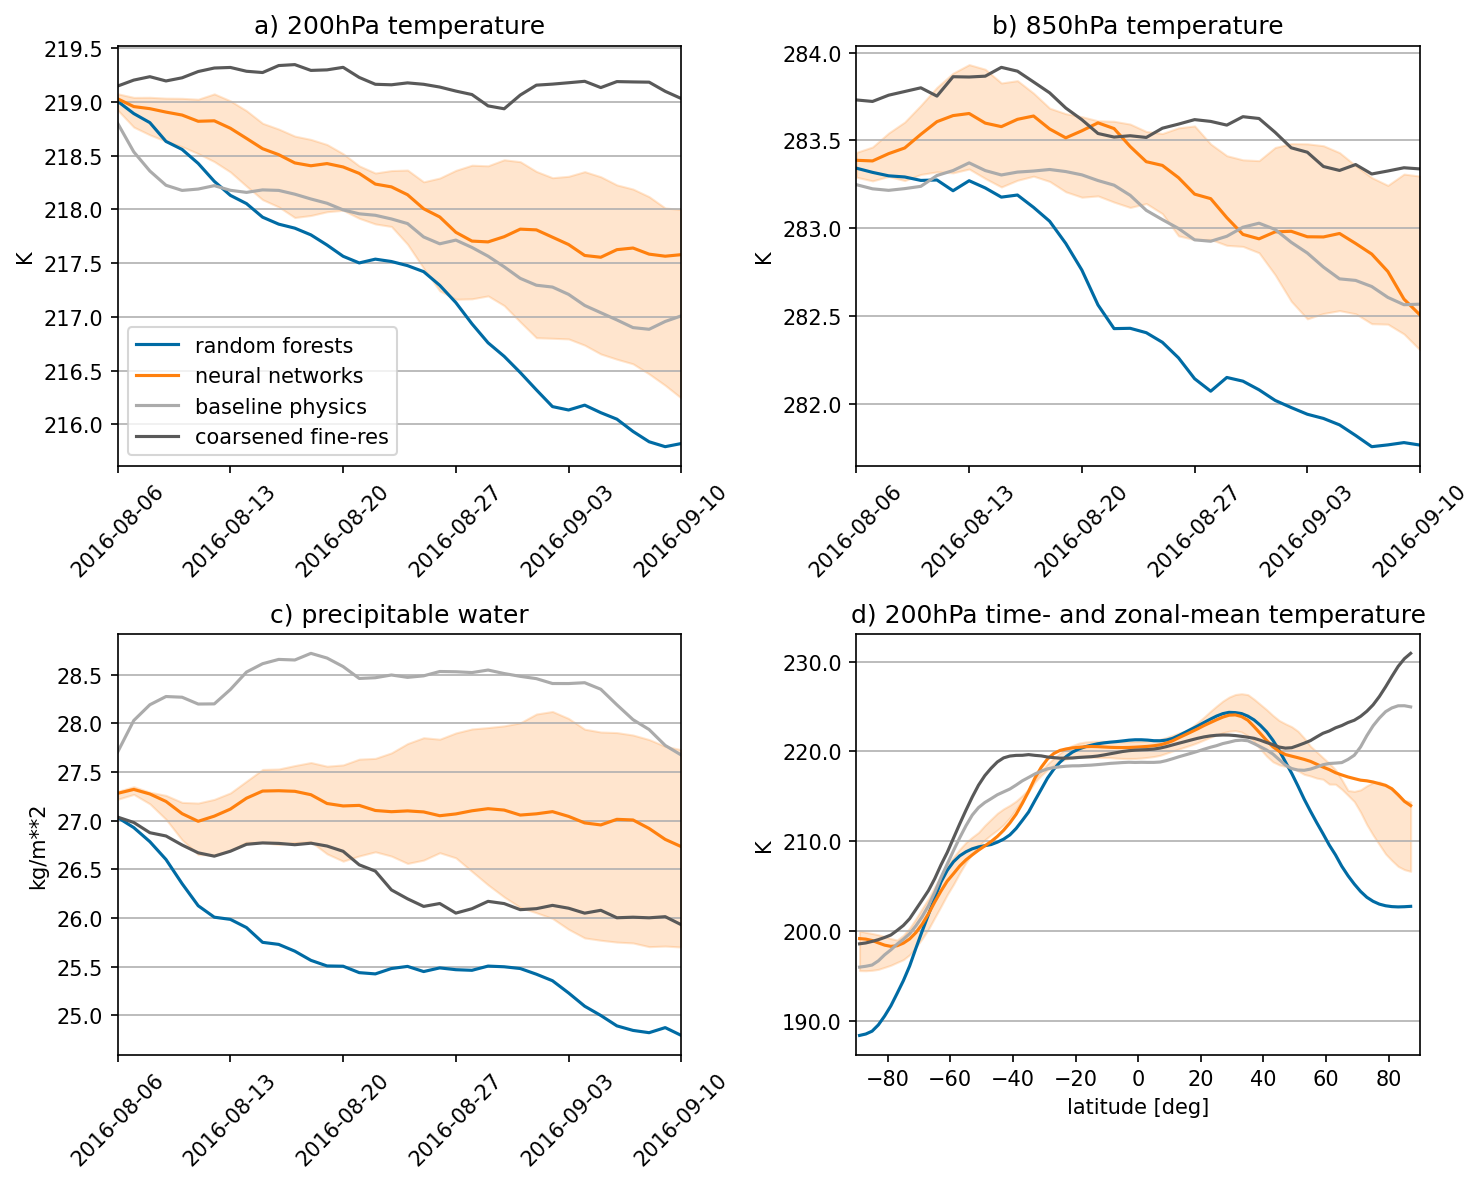

In [7]:
plot_global_drifts(run_list, list(DRIFT_TS_VARS.keys()) + ['200hPa time- and zonal-mean temperature'])

In [14]:
def plot_temp_bias_lat_pressure(run_list, fig_size=[12, 4]):
    verif_temp_lat_pressure = [run for run in run_list if run.verif == True][0].mean_temp_lat_pressure
    prog_runs = [run for run in run_list if run.verif is False and "NN-seed" not in run.name]
    run_names = [run.name for run in prog_runs]
    temperature_bias = (
        xr.concat(
            [run.mean_temp_lat_pressure for run in prog_runs],
            dim=xr.DataArray(run_names, dims='runs', coords={'runs': run_names})
        ) - verif_temp_lat_pressure
    ).assign_attrs({'long_name': 'air temperature bias', 'units': 'K'})
    fg = temperature_bias.plot(col='runs', col_wrap=3, yincrease=False, vmin=-10, vmax=10, cmap='RdBu_r')
    fg.set_titles('{value}')
    fg.set_xlabels('latitude [deg]')
    fg.set_ylabels('pressure [Pa]')
    fg.fig.set_size_inches(fig_size)
    fg.fig.set_dpi(150)
    fg.fig.savefig(f"{OUTDIR}/prognostic_temperature_bias_zonal_lat.png", bbox_inches='tight', facecolor='white')

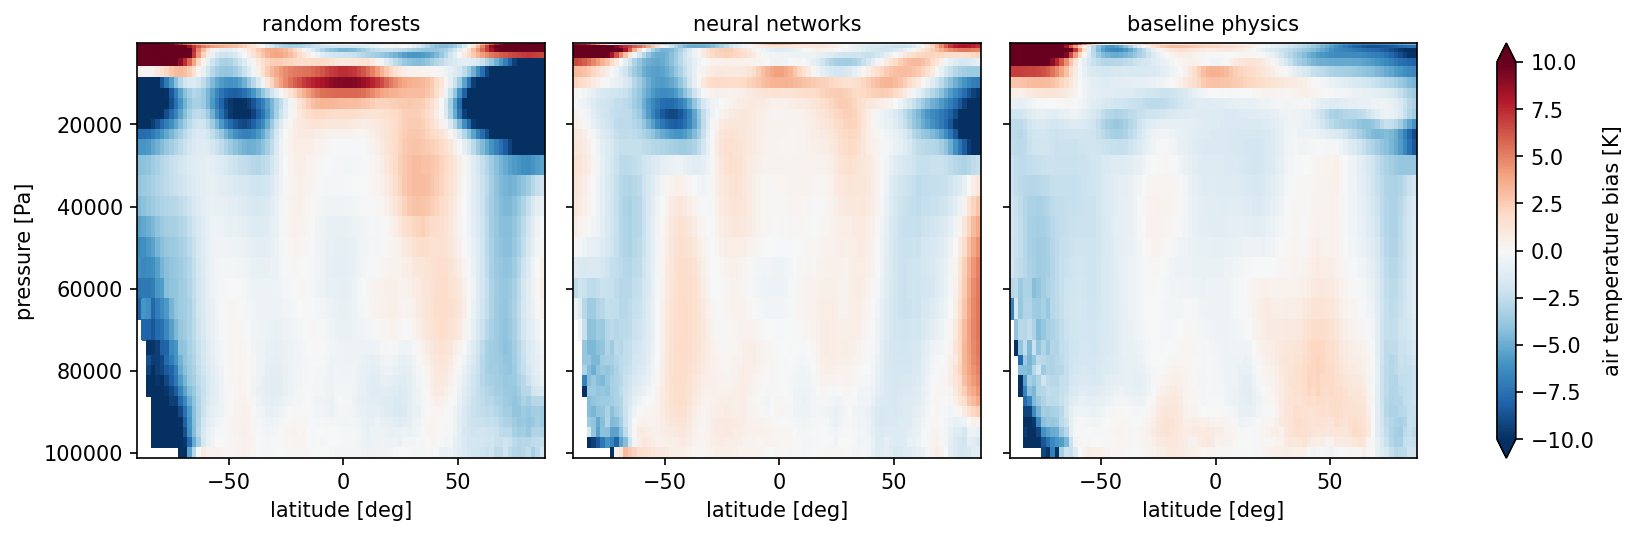

In [15]:
plot_temp_bias_lat_pressure(run_list)